### Disclaimer

The following notebook was compiled for the course 'Geostatistics' at Ghent University (lecturer-in-charge: Prof. Dr. Ellen Van De Vijver; teaching assistant: Pablo De Weerdt). It consists of notebook snippets created by Michael Pyrcz. The code and markdown (text) snippets were edited specifically for this course, using the 'Jura data set' (Goovaerts, 1997) as example in the practical classes. Some new code snippets are also included to cover topics which were not found in the Geostastpy package demo books. In this case the inverse distance weighting and cross validation code was written by P. De Weerdt. <br> 

This notebook is for educational purposes.<br> 

Guidelines for getting started were adapted from the 'Environmental Soil Sensing' course at Ghent University (lecturer-in-charge: Prof. Dr. Philippe De Smedt).<br> 

The Jura data set was taken from: Goovaerts P., 1997. Geostatistics for Natural Resources Evaluation. Oxford University Press.

**Don't forget to save a copy on your Google drive before starting**

You can also 'mount' your Google Drive in Google colab to directly access your Drive folders (e.g. to access data, previous notebooks etc.)

Do not hesitate to contact us for questions or feel free to ask questions during the practical sessions.

# Geostatistics: Introduction to geostatistical data analysis with Python

In [2]:
# Import required packages for setup
# -------------------------------------------- #

import sys
import os

In [ ]:
#  Clone the repository and add it to the path
if 'google.colab' in sys.modules:
    !git clone https://github.com/SENSE-UGent/E_I002454_Geostatistics.git
    sys.path.append('/content/E_I002454_Geostatistics') #Default location in Google Colab after cloning
else:
    # if you are not using Google Colab, change the path to the location of the repository
    sys.path.append(r'c:\Users\pdweerdt\Documents\Repos\E_I002454_Geostatistics')
    
# Import the setup function
from Utils.setup import check_and_install_packages

# Read the requirements.txt file
if 'google.colab' in sys.modules:
    requirements_path = '/content/E_I002454_Geostatistics/Utils/requirements.txt'
else:
    requirements_path = 'c:/Users/pdweerdt/Documents/Repos/E_I002454_Geostatistics/Utils/requirements.txt'

with open(requirements_path) as f:
    required_packages = f.read().splitlines()

# Check and install packages
check_and_install_packages(required_packages)

#### Load Required libraries

In [4]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilities, visualization and wrapper
import geostatspy as geostats
print('GeostatsPy version: ' + str(geostats.__version__))   # these notebooks were tested with GeostatsPy version: 0.0.72

GeostatsPy version: 0.0.72


We will also need some standard packages. These should have been installed.

In [5]:
from tqdm import tqdm                                         # suppress the status bar
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)
                                   
import numpy as np                                            # ndarrays for gridded data
                                       
import pandas as pd                                           # DataFrames for tabular data

import matplotlib.pyplot as plt                               # for plotting

from scipy import stats                                       # summary statistics

from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression

import scipy.special

plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements

ignore_warnings = True                                        # ignore warnings?
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')

from IPython.utils import io                                  # mute output from simulation

seed = 42                                                     # random number seed

In [6]:
from Utils.func import inverse_distance_weighting

### Optional libraries

These are not required to run the given version of this practical exercise, but might be useful if you want to extend this notebook with more code.

In [46]:
#  import math library
import math

In [50]:
from scipy.stats import pearsonr                              # Pearson product moment correlation
from scipy.stats import spearmanr                             # spearman rank correlation    
                                   
import seaborn as sns                                         # advanced plotting

import matplotlib as mpl                                        

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib.colors import ListedColormap 
import matplotlib.ticker as mtick 
import matplotlib.gridspec as gridspec

### Set the Working Directory

Do this to simplify subsequent reads and writes (avoid including the full address each time). 

##### For use in Google Colab

Run the following cell if you automatically want to get the data from the repository and store it on your Google Colab drive

In [ ]:
# change the working directory to the cloned repository

os.chdir('E_I002454_Geostatistics')

# get the current directory and store it as a variable

cd = os.getcwd()
print("Current Working Directory is " , cd)

##### For local use

Only run the following cell if you have the data locally stored.

In [7]:
# set the working directory, place an r in front to address special characters
os.chdir(r'C:\\Users\\pdweerdt\\OneDrive - UGent\\I002454 - Geostatistics\\AY 2024-2025\\Practicals')

# get the current directory and store it as a variable

cd = os.getcwd()
print("Current Working Directory is " , cd)

Current Working Directory is  C:\Users\pdweerdt\OneDrive - UGent\I002454 - Geostatistics\AY 2024-2025\Practicals


### Loading Tabular & Gridded Data

Here's the section to load our data file into a Pandas' DataFrame object.

Let's load and visualize a grid also.

Check the datatype of your gridded data.

In this case it is actually also a .dat file, so we can use the same function to import it. The .grid extension was given to indicate that it is gridded data.

In [8]:
# Here you can adjust the relative Path to the data folder

data_path = cd + '/Hard_data' 

In [9]:
file_name = '//prediction.dat'

df = GSLIB.GSLIB2Dataframe(data_path + file_name) # read the data

df.head()

Xloc   Yloc  Landuse  Rock     Cd     Co     Cr     Cu     Ni     Pb  \
0  2.386  3.077      3.0   3.0  1.740   9.32  38.32  25.72  21.32  77.36   
1  2.544  1.972      2.0   2.0  1.335  10.00  40.20  24.76  29.72  77.88   
2  2.807  3.347      2.0   3.0  1.610  10.60  47.00   8.88  21.40  30.80   
3  4.308  1.933      3.0   2.0  2.150  11.92  43.52  22.70  29.72  56.40   
4  4.383  1.081      3.0   5.0  1.565  16.32  38.52  34.32  26.20  66.40   

      Zn  
0  92.56  
1  73.56  
2  64.80  
3  90.00  
4  88.40

In [10]:
grid_file_name = '//rocktype.grid'

# load the data

df_grid = GSLIB.GSLIB2Dataframe(data_path + grid_file_name)

df_grid.head()

x     y  rocktype
0  0.3  1.65       3.0
1  0.3  1.70       3.0
2  0.3  1.75       3.0
3  0.3  1.80       2.0
4  0.3  2.15       1.0

In [ ]:
df_grid.x.describe() 

### Define feature of interest

In [11]:
feature = 'Cd'
unit = 'ppm'

## Calculate some statistics

In P1 we calculated some statistics

In [12]:
min_feat = round((df[feature].values).min(), 2)                    # calculate the minimum
max_feat = round((df[feature].values).max(), 2)                    # calculate the maximum
mean_feat = round((df[feature].values).mean(), 2)                  # calculate the mean
stdev_feat = round((df[feature].values).std(), 2)                  # calculate the standard deviation
n_feat = df[feature].values.size                                   # calculate the number of data

print('The minimum is ' + str(min_feat) + ' ' + str(unit) + '.')   # print univariate statistics
print('The maximum is ' + str(max_feat) + ' ' + str(unit) + '.')
print('The mean is ' + str(mean_feat) + ' ' + str(unit) + '.')
print('The standard deviation is ' + str(stdev_feat) + ' ' + str(unit) + '.')
print('The number of data is ' + str(n_feat) + '.')


The minimum is 0.14 ppm.
The maximum is 5.13 ppm.
The mean is 1.31 ppm.
The standard deviation is 0.91 ppm.
The number of data is 259.


In P1 we already ran some code for plotting spatial data, this is always a good first step in spatial analysis.

## Plotting Spatial Data

####  Colorbar

Check the 
* [Matplotlib colormaps](https://matplotlib.org/stable/users/explain/colors/colormaps.html) for plotting with matplotlib
* [seaborn color palettes](https://seaborn.pydata.org/generated/seaborn.color_palette.html) for plotting with seaborn

In [ ]:
#  define a colormap

cmap = plt.cm.inferno                                         # color map inferno

cmap_rainb = plt.cm.turbo # similar to what is shown on the slides


#### Specify the Area of Interest / Grid and Feature Limits

Let's specify a reasonable extents for our grid and features:

* we do this so we have consistent plots for comparison. 

* we design a grid that balances detail and computation time. Note kriging computation complexity scales

* so if we half the cell size we have 4 times more grid cells in 2D, 4 times the runtime

We could use commands like this one to find the minimum value of a feature:
```python
df[feature].min()
```
* But, it is natural to set the ranges manually. e.g. do you want your color bar to go from 0.05887 to 0.24230 exactly? 

In [14]:
xmin = 0; xmax = np.ceil(df.Xloc.max())                                   # range of x values
ymin = 0; ymax = np.ceil(df.Yloc.max())                                   # range of y values

#### Visualizing Tabular Data with Location Maps

Let's try out locmap. This is a reimplementation of GSLIB's locmap program that uses matplotlib.

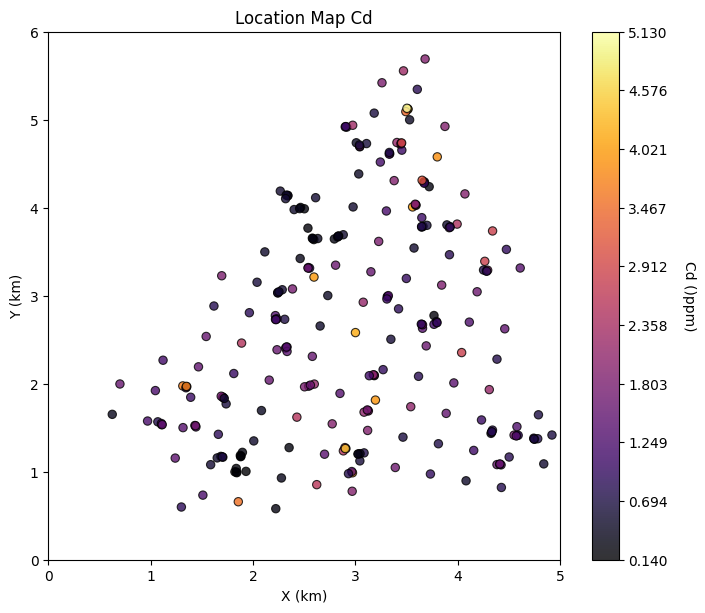

In [57]:
GSLIB.locmap_st(
                df, 'Xloc', 'Yloc', feature, xmin, xmax, ymin, ymax, 
                min_feat, max_feat, # set the value range for the color map
                ('Location Map ' + str(feature)),'X (km)','Y (km)',
                (str(feature) + ' ()' + str(unit) + ')'), cmap
                )

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.1, hspace=0.2); plt.show()

## Build a Estimation Map

Now we check the method by building maps with 3 different powers.

* First we specify a grid and then rerun inverse distance for each map.

In [56]:
# have a look at the function first
help(inverse_distance_weighting)

Help on function inverse_distance_weighting in module Utils.func:

inverse_distance_weighting(data=nan, grid_points=nan, data_x_col=nan, data_y_col=nan, data_z_col=nan, grid_x_col=nan, grid_y_col=nan, grid_z_col=nan, o_col=nan, power=nan, max_points=nan, min_points=nan, search_radii=nan)



In [16]:
# Let's start with a power of 2

power = 2
max_points = 15
min_points = 2
search_radii = [2, 2]

# perform IDW
inverse_distance_weighting(data=df, grid_points=df_grid, data_x_col='Xloc', data_y_col='Yloc', 
                             o_col=feature, grid_x_col='x', grid_y_col='y', 
                             power=power, max_points=max_points, min_points=min_points, search_radii=search_radii )

The function has finished. The predictions are in the grid_points DataFrame in the column idw2Cd


### Grid visualisation of results

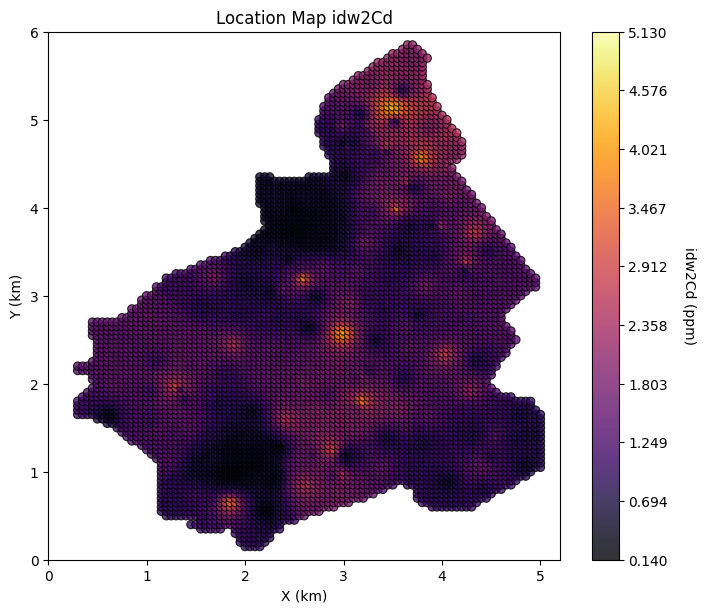

In [17]:
grid_feature = 'idw' + str(power) + feature

GSLIB.locmap_st(df_grid,'x', 'y', grid_feature,
                0, 5.2, ymin, ymax, 
                min_feat, max_feat, # set the value range for the color map
                (
                    'Location Map ' 
                 + str(grid_feature)
                 ), 
                 'X (km)', 'Y (km)',
             (
                 str(grid_feature) + ' (' + str(unit) + ')'
                 ), cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.1, hspace=0.2)

#### Check the Impact of the power

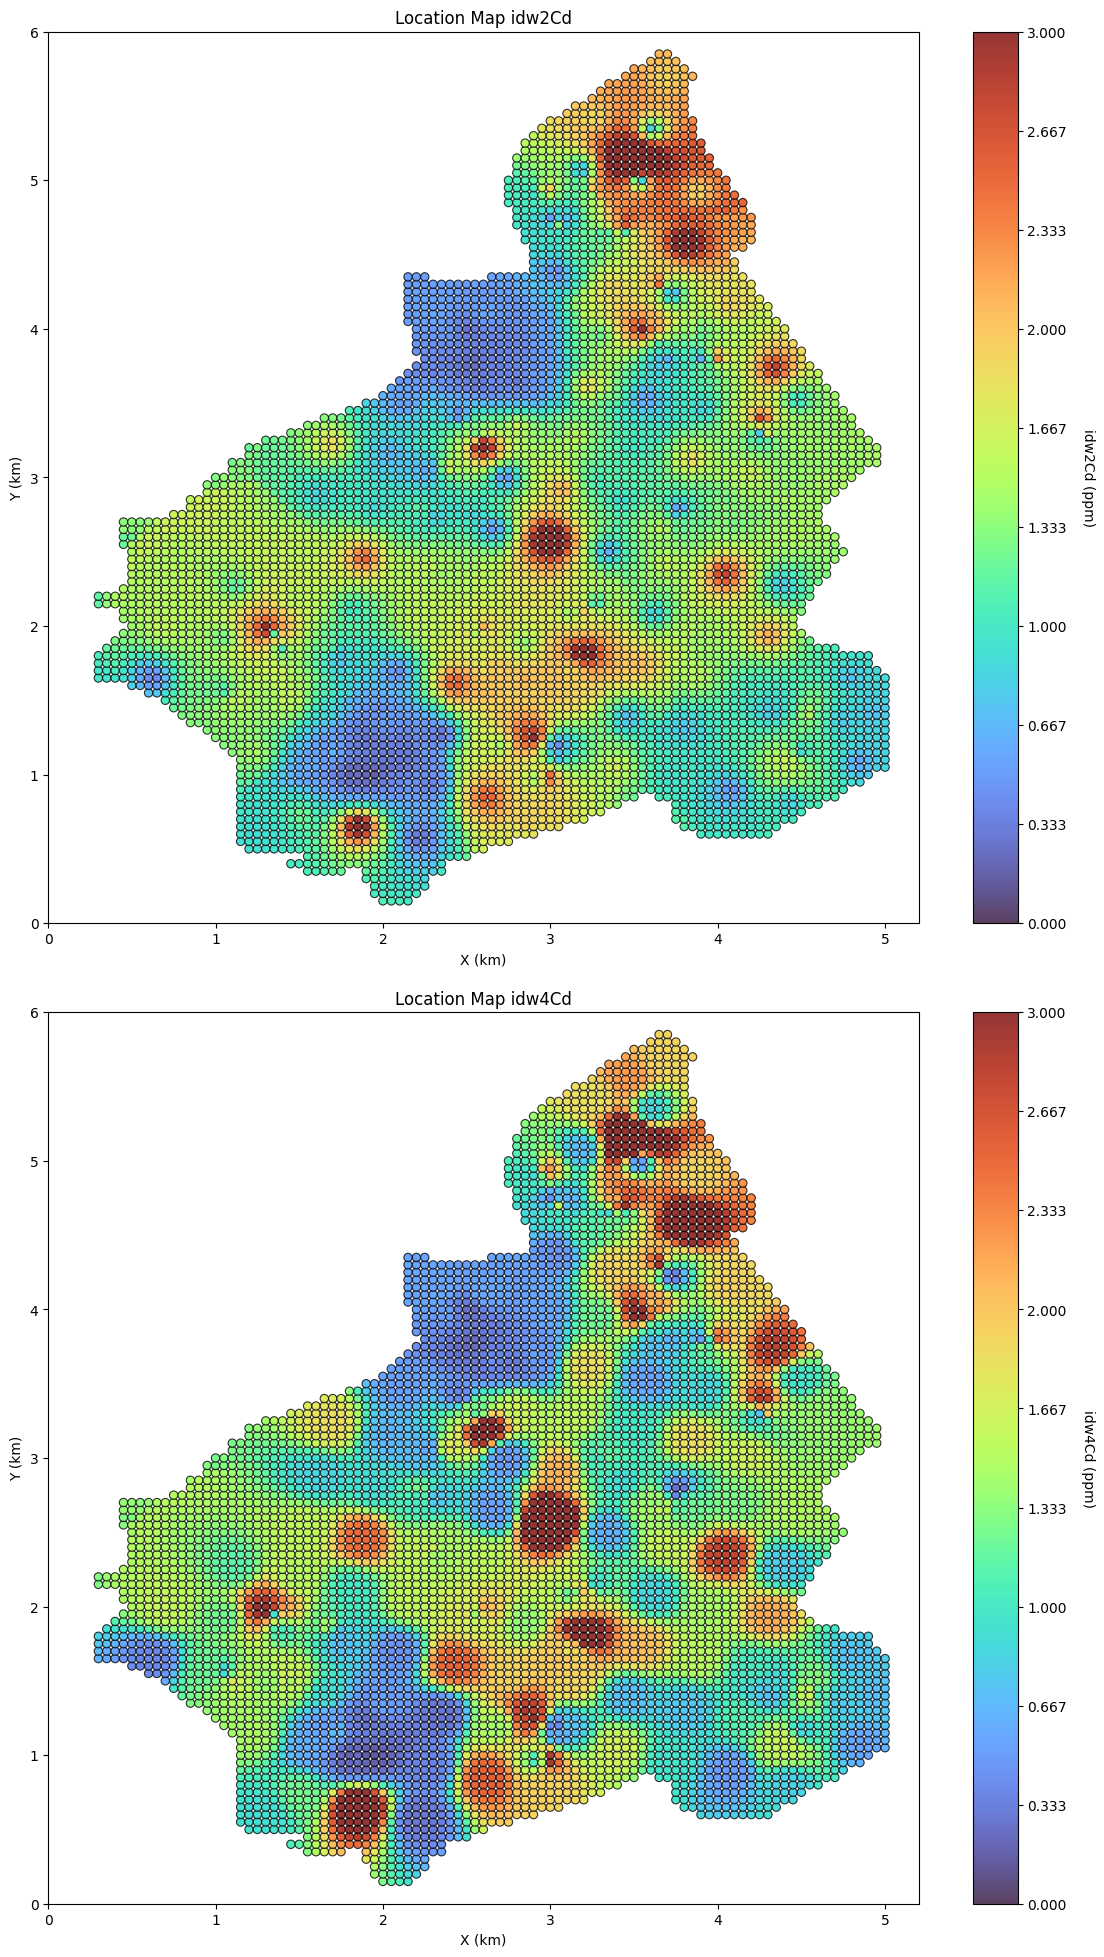

In [55]:
%%capture --no-display

# first set the power to a fixed value

min_points = 2
max_points = 15
search_radii = [1, 1]

# set the search radii that you want to compare
power_imp = [2, 4]

# set the search radii for the function, and iterate the idw function over the search radii
for i, power in enumerate(power_imp):

    # perform IDW
    inverse_distance_weighting(data=df, grid_points=df_grid, data_x_col='Xloc', data_y_col='Yloc', 
                             o_col=feature, grid_x_col='x', grid_y_col='y', 
                             power=power, max_points=max_points, min_points=min_points, search_radii=search_radii)

    grid_feature = 'idw' + str(power) + feature

    # plot the results
    plt.subplot(len(power_imp), 1, i + 1)
    GSLIB.locmap_st(df_grid, 'x', 'y', grid_feature,
                    0, 5.2, ymin, ymax,
                    0, 3,  # set the value range for the color map
                    (
                        'Location Map '
                        + str(grid_feature)
                    ),
                    'X (km)', 'Y (km)',
                    (
                        str(grid_feature) + ' (' + str(unit) + ')'
                    ), cmap_rainb)
plt.subplots_adjust(left=0.1, bottom=0.1, right=1.8, top=4, wspace=0.4, hspace=0.1)
plt.show()

## Cross validation
in this part we will perform a cross-validation to determine the optimal power parameter.

In [ ]:


val_method = 'xv'

max_points = 64
min_points = 2
search_radii = [1,1]

feature = 'Cd'

# We will compare validation results for different power values
power_imp = [2, 4]

# Initialize empty lists to add to the results df
power_vals = []
val_method_vals = []

MPE_vals = []
MSPE_vals = []
RMSPE_vals = []
MAPE_vals = []
rel_nna_vals = []
Pr_vals = []
Sr_vals = []

results_df_xv = pd.DataFrame()

for power in power_imp:

    # Perform leave-one-out cross validation, initialize variables

    a_c = 0 # for the cumulative error
    a = 0 # for the error
    a_c_a = 0 #for the absolute cum error
    a_c_s = 0 #for the squared cum error

    #Initiate empty list to store results
    p_list = []

    # Split into prediction and validation sets by leaving one observation out in each iteration
    for i in range(df.shape[0]):
        data_pred = df.drop(i).reset_index(drop = True)
        data_val = df.iloc[i].to_frame().T
        data_val['idw' + str(power) + feature] = '' #function requires a 'p' column to append prediction results to
        data_val['r'] = '' #add empty column for residuals

        # Perform IDW
        inverse_distance_weighting(data=data_pred, grid_points=data_val, data_x_col='Xloc', data_y_col='Yloc',
                                    o_col=feature, grid_x_col='Xloc', grid_y_col='Yloc', power=power, max_points=max_points,
                                    min_points=min_points, search_radii=search_radii)

        p_list.extend(data_val['idw' + str(power) + feature].tolist())

        # Calculate error on test set
        data_val['r'] = data_val['idw' + str(power) + feature] - data_val[feature] 

        # print("r-value ", data_val['r'])

        data_val['r_s'] = data_val['r']**2

        data_val['r_a'] = data_val['r'].abs()

        # Calculate average error
        a = data_val['r'].mean()

        a_s = data_val['r_s'].mean()

        a_a = data_val['r_a'].mean()

        if not pd.isna(a):

            a_c += a #cumulative error
            # print("a_c value", a_c)
            a_c_a += a_a #cumulative absolute error

            a_c_s += a_s

    # Check if the number of elements in the list is equal to the number of rows in the dataframe

    if len(p_list) != df.shape[0]:
        raise ValueError("The list and dataframe have different sizes")
        
    else:
        df['idw' + str(power) + feature + val_method] = p_list
        print(len(p_list))

    # Round ac and aca
    a_c = round(a_c, 2)
    a_c_a = round(a_c_a, 2)
    a_c_s = round(a_c_s, 2)

    #calculate Mean prediction error
    MPE = round(a_c/n_feat, 2)

    print("Mean Prediction Error:", MPE)    

    #Calculate Mean squared prediction error
    MSPE = round(a_c_s/n_feat, 2)
    print("Mean Squared Prediction Error:", MSPE)

    #Calculate Root mean squared prediction error
    RMSPE = round(math.sqrt(a_c_s/n_feat), 2)
    print("Root Mean Squared Prediction Error:", RMSPE)

    #calculate Mean absolute prediction error
    MAPE = round(a_c_a/n_feat, 2)
    print("Mean Absolute Prediction Error:", MAPE)

    #Pearson correlation coefficient
    #read in the data, drop na to avoid errors
    data_cor = df.dropna(subset=[feature, 'idw' + str(power) + feature + val_method])

    #extract the columns of interest 
    x = data_cor[feature]
    y = data_cor['idw' + str(power) + feature + val_method]

    #calculate the Pearson's correlation coefficient 
    corr_p, _ = pearsonr(x, y)
    corr_p = round(corr_p, 2)
    print('Pearsons correlation: %.3f' % corr_p)

    # Spearman's Correlation:
    #calculate the Spearman's correlation coefficient 
    corr_s, _ = spearmanr(x, y)
    corr_s = round(corr_s, 2)
    print('Spearmans correlation: %.3f' % corr_s)

    # Store the index values in the respective lists
    MPE_vals.append(MPE)
    MSPE_vals.append(MSPE)
    RMSPE_vals.append(RMSPE)
    MAPE_vals.append(MAPE)
    Pr_vals.append(corr_p)
    Sr_vals.append(corr_s)
    power_vals.append(power)
    val_method_vals.append(val_method)

# Create a new DataFrame to store the results for this variable and parameter settings
results_temp_df = pd.DataFrame()
results_temp_df['idw_power'] = power_vals
results_temp_df['ValidationMethod'] = val_method_vals
results_temp_df['MPE'] = MPE_vals
results_temp_df['MSPE'] = MSPE_vals
results_temp_df['RMSPE'] = RMSPE_vals
results_temp_df['MAPE'] = MAPE_vals
results_temp_df['PearsonCorr'] = Pr_vals
results_temp_df['SpearmanCorr'] = Sr_vals

# Append the results for this variable and parameter settings to the main DataFrame
results_df_xv_2d = pd.concat([results_df_xv, results_temp_df], ignore_index=True)

results_df_xv_2d.head()

The function has finished. The predictions are in the grid_points DataFrame in the column idw2Cd
The function has finished. The predictions are in the grid_points DataFrame in the column idw2Cd
The function has finished. The predictions are in the grid_points DataFrame in the column idw2Cd
The function has finished. The predictions are in the grid_points DataFrame in the column idw2Cd
The function has finished. The predictions are in the grid_points DataFrame in the column idw2Cd
The function has finished. The predictions are in the grid_points DataFrame in the column idw2Cd
The function has finished. The predictions are in the grid_points DataFrame in the column idw2Cd
The function has finished. The predictions are in the grid_points DataFrame in the column idw2Cd
The function has finished. The predictions are in the grid_points DataFrame in the column idw2Cd
The function has finished. The predictions are in the grid_points DataFrame in the column idw2Cd
The function has finished. The

idw_power ValidationMethod   MPE  MSPE  RMSPE  MAPE  PearsonCorr  \
0          2               xv  0.01  0.62   0.79  0.51         0.55   
1          4               xv  0.02  0.70   0.84  0.54         0.52   

   SpearmanCorr  
0          0.61  
1          0.60

Discuss the validation indices...

# Some Extra code

#### Check the Impact of Radius

Radius is the maximum distance to look for neighbouring data

* limited radius may result is image artifacts as data abruptly are excluded

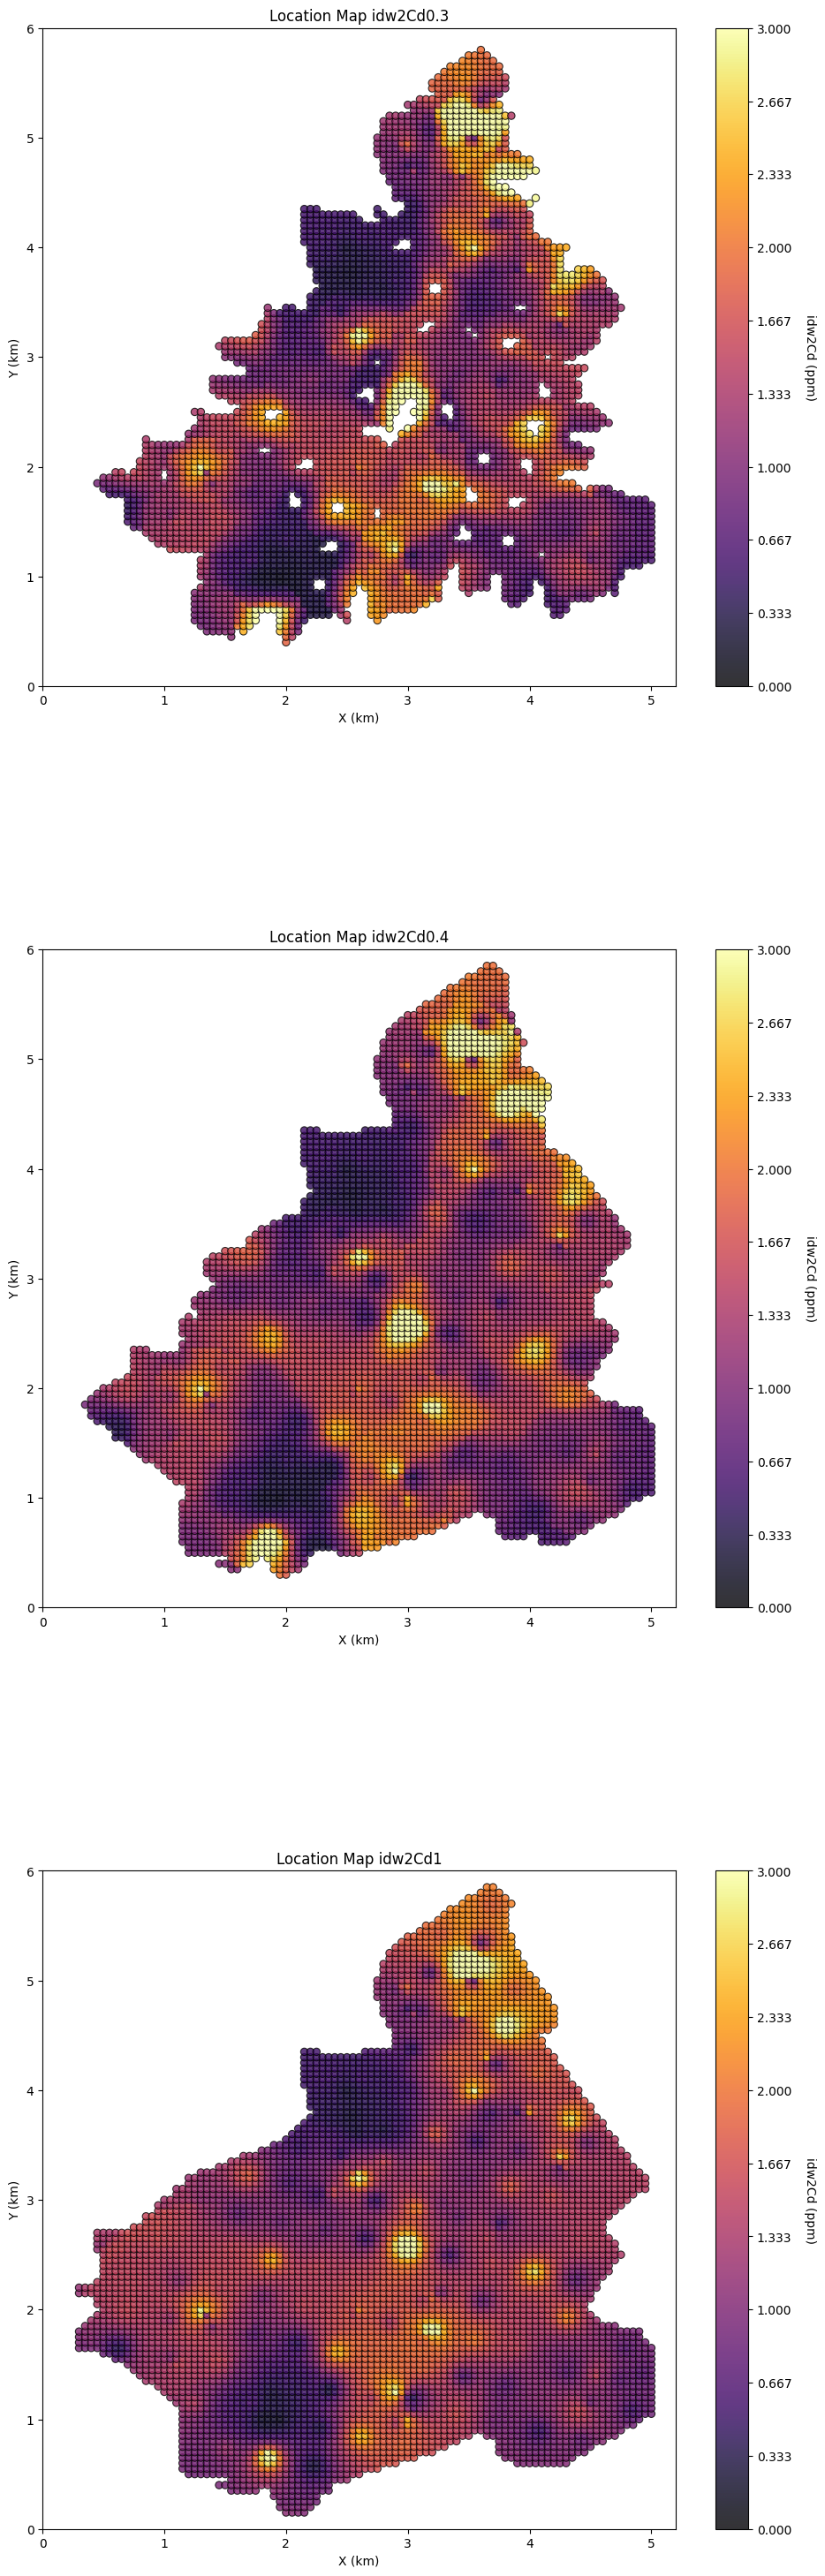

In [ ]:
%%capture --no-display

# first set the power to a fixed value
power = 2
min_points = 2
max_points = 25

# set the search radii that you want to compare
search_radii_imp = [0.3, 0.4, 1]

# set the search radii for the function, and iterate the idw function over the search radii
for i, search_radius in enumerate(search_radii_imp):

    search_radii = [search_radius, search_radius]

    # perform IDW
    inverse_distance_weighting(data=df, grid_points=df_grid, data_x_col='Xloc', data_y_col='Yloc', 
                             o_col=feature, grid_x_col='x', grid_y_col='y', 
                             power=power, max_points=max_points, min_points=min_points, search_radii=search_radii)

    grid_feature = 'idw' + str(power) + feature

    # plot the results
    plt.subplot(len(search_radii_imp), 1, i + 1)
    GSLIB.locmap_st(df_grid, 'x', 'y', grid_feature,
                    0, 5.2, ymin, ymax,
                    0, 3,  # set the value range for the color map
                    (
                        'Location Map '
                        + str(grid_feature)
                        + str(search_radius)
                    ),
                    'X (km)', 'Y (km)',
                    (
                        str(grid_feature) + ' (' + str(unit) + ')'
                    ), cmap)
plt.subplots_adjust(left=0.1, bottom=0.1, right=1.5, top=6, wspace=0.4, hspace=0.4)
plt.show()